### 1. Setup and Imports

In [3]:
pip install geopy

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Libraries
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import time



###  2.Fetch Raw Data

In [5]:
# Fetch datasets and combine them
def fetch_and_combine_datasets(dataset_ids, base_url):
    """
    Fetch and combine datasets from the specified URLs, standardizing schema across years.
    """
    dataframes = []
    for dataset_id in dataset_ids:
        url = f'{base_url}{dataset_id}/exports/csv'
        try:
            response = requests.get(url)
            response.raise_for_status()
            df = pd.read_csv(StringIO(response.content.decode('utf-8')), delimiter=';', on_bad_lines='skip')
            if 'respondent_group0' in df.columns:
                df.rename(columns={'respondent_group0': 'respondent_group'}, inplace=True)
            dataframes.append(df)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching dataset {dataset_id}: {e}")
            continue
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# Constants for dataset fetching
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
DATASET_IDS = [
    'social-indicators-for-city-of-melbourne-residents-2023',
    'social-indicators-for-city-of-melbourne-residents-2022',
    'social-indicators-for-city-of-melbourne-residents-2021',
    'social-indicators-for-city-of-melbourne-residents-2020',
    'social-indicators-for-city-of-melbourne-residents-2019',
    'social-indicators-for-city-of-melbourne-residents-2018'
]

# Fetch and save raw data
print("Fetching datasets...")
raw_data = fetch_and_combine_datasets(DATASET_IDS, BASE_URL)
if not raw_data.empty:
    raw_data.to_csv("data/raw/raw_combined.csv", index=False)
    print("Raw data saved to 'data/raw/raw_combined.csv'.")
else:
    print("No datasets fetched.")



Fetching datasets...
Raw data saved to 'data/raw/raw_combined.csv'.


### 3. Clean and Organize Data

In [6]:
# Data Cleaning
def organize_subjective_wellbeing_data(dataframe):
    """
    Process and organize the 'Subjective wellbeing' dataset:
    - Filters data for 'Subjective wellbeing' topics.
    - Drops unnecessary columns.
    - Adds a 'Category' column based on 'respondent_group' for classification.
    - Reorganizes and renames columns for clarity.
    """
    # Step 1: Filter for rows where the topic is 'Subjective wellbeing'
    filtered_df = dataframe[dataframe['topic'] == 'Subjective wellbeing']

    # Step 2: Drop unnecessary columns (if they exist)
    drop_columns = ['indicator', 'topic', 'type', 'response', 'format', 'sample_size']
    filtered_df = filtered_df.drop(columns=[col for col in drop_columns if col in filtered_df.columns], errors='ignore')

    # Step 3: Add a 'Category' column based on respondent grouping
    def categorize_respondent_group(row):
        if row.get('respondent_group') in ['Male', 'Female']:
            return 'Gender'
        elif row.get('respondent_group') in ['18-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65+ years']:
            return 'Age Group'
        elif row.get('respondent_group') in ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']:
            return 'Age Group'
        else:
            return 'Suburb'

    filtered_df['Category'] = filtered_df.apply(categorize_respondent_group, axis=1)

    # Step 4: Reorganize and rename columns for clarity
    reorganized_df = filtered_df[['description', 'Category', 'respondent_group', 'year', 'result']]
    reorganized_df = reorganized_df.rename(columns={
        'description': 'Subtopics',
        'respondent_group': 'Subcategory',
        'result': 'Percentage'
    })

    # Adjust the index to start from 1
    reorganized_df.index += 1

    # Standardize Subcategory names
    corrections = {
        '18-24': '18-24 years', '24-34': '24-34 years', '25-34': '25-34 years',
        '35-44': '35-44 years', '45-54': '45-54 years', '55-64': '55-64 years',
        '65+': '65+ years', 'Kensington/ Flemingon 3031': 'Kensington / Flemington 3031',
        'South Yarra 3141 / Melbourne (St Kilda Road) 3004': 'South Yarra 3141 / Melbourne/St Kilda Road 3004',
        'Southbank/ South Wharf 3006': 'South Wharf / Southbank 3006'
    }
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace(corrections)

    return reorganized_df

# Clean and save processed data
print("Cleaning and organizing data...")
cleaned_data = organize_subjective_wellbeing_data(raw_data)
cleaned_data.to_csv("data/processed/subjective_wellbeing_cleaned.csv", index=False)
print("Cleaned data saved to 'data/processed/subjective_wellbeing_cleaned.csv'.")

Cleaning and organizing data...
Cleaned data saved to 'data/processed/subjective_wellbeing_cleaned.csv'.


### 4. Generate and Save Visualizations

In [7]:
# Validation Script
def validate_cleaned_data(dataframe):
    """
    Validate the cleaned dataset for missing values, duplicates, and consistency.
    """
    print("Validating cleaned data...")
    missing_values = dataframe.isnull().sum().sum()
    duplicates = dataframe.duplicated().sum()
    print(f"Missing values: {missing_values}")
    print(f"Duplicate rows: {duplicates}")
    print("Validation complete!")

# Validate cleaned data
validate_cleaned_data(cleaned_data)

Validating cleaned data...
Missing values: 0
Duplicate rows: 0
Validation complete!


### 5.Generate and Save Visualizations

Generating static visualizations...


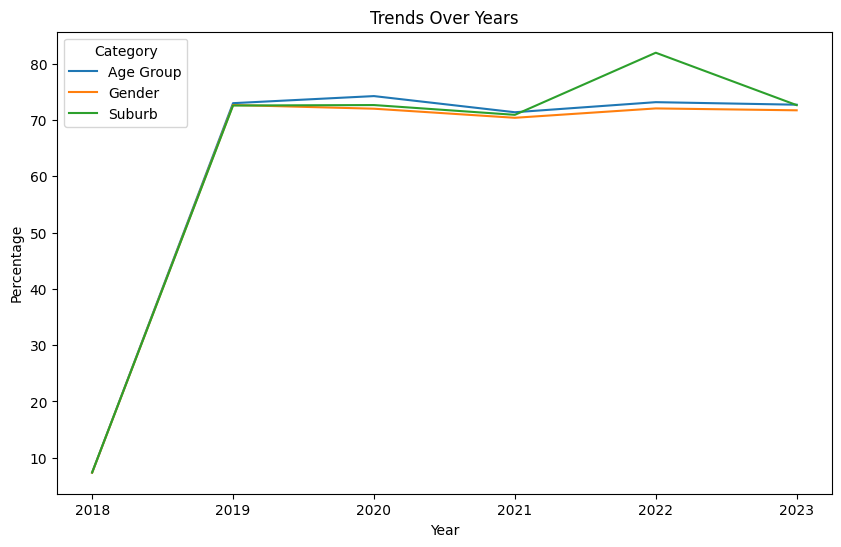

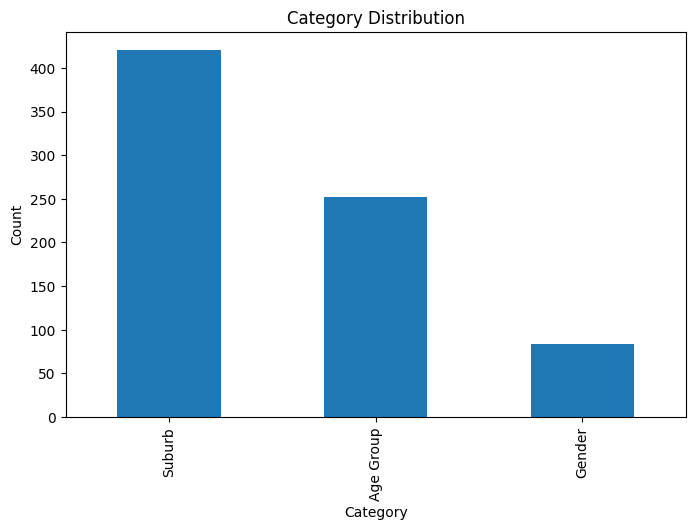

Static visualizations saved to 'visualizations/static/'.


In [8]:
# Static Visualizations
def generate_static_visualizations(dataframe):
    """
    Generate and save static visualizations.
    """
    # Line plot for trends over years
    trends = dataframe.groupby(['year', 'Category'])['Percentage'].mean().unstack()
    trends.plot(kind='line', figsize=(10, 6), title='Trends Over Years')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.savefig('visualizations/static/trends_over_years.png')
    plt.show()

    # Bar chart for category distributions
    category_counts = dataframe['Category'].value_counts()
    category_counts.plot(kind='bar', figsize=(8, 5), title='Category Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.savefig('visualizations/static/category_distributions.png')
    plt.show()

# Generate static visualizations
print("Generating static visualizations...")
generate_static_visualizations(cleaned_data)
print("Static visualizations saved to 'visualizations/static/'.")

### 6. Interactive Visualizations

In [9]:
# Interactive Visualizations
def generate_interactive_visualizations(dataframe):
    """
    Generate and save interactive visualizations.
    """
    # Interactive line chart
    fig = px.line(dataframe, x='year', y='Percentage', color='Category',
                  title='Interactive Trends Over Years')
    fig.write_html("visualizations/interactive/trends_over_years.html")

    # Interactive bar chart
    fig = px.bar(dataframe, x='Category', y='Percentage', color='Category',
                 title='Interactive Category Distribution')
    fig.write_html("visualizations/interactive/category_distributions.html")

# Generate interactive visualizations
print("Generating interactive visualizations...")
generate_interactive_visualizations(cleaned_data)
print("Interactive visualizations saved to 'visualizations/interactive/'.")

Generating interactive visualizations...
Interactive visualizations saved to 'visualizations/interactive/'.


In [10]:
# Load Cleaned Data
data_path = "data/processed/subjective_wellbeing_cleaned.csv"
data = pd.read_csv(data_path)

# Ensure data is loaded correctly
print(data.head())

                              Subtopics   Category   Subcategory  year  \
0  Satisfaction with standard of living  Age Group   35-44 years  2023   
1  Satisfaction with standard of living  Age Group   55-64 years  2023   
2  Satisfaction with standard of living  Age Group     65+ years  2023   
3  Satisfaction with standard of living     Gender        Female  2023   
4  Satisfaction with standard of living     Suburb  Carlton 3053  2023   

   Percentage  
0        73.4  
1        79.4  
2        85.7  
3        74.9  
4        68.7  


### Preprocess Data

In [11]:
# Convert categorical columns to numeric using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['Category', 'Subcategory', 'Subtopics'], drop_first=True)

# Split data into features (X) and target (y)
X = data_encoded.drop(columns=['year', 'Percentage'])
y = data_encoded['Percentage']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (604, 25)
Test set size: (152, 25)


### Train Models

In [12]:
# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Evaluate Models

In [13]:
# Evaluate Linear Regression
y_pred_linear = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Linear Regression - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}")

Linear Regression - MAE: 17.29201600564567, RMSE: 23.998801925944864
Random Forest - MAE: 21.16923823153272, RMSE: 29.763623495519024


###  Save the Best Model

In [14]:
# Save the best-performing model (Random Forest in this case)
best_model = rf_model
model_path = "models/wellbeing_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved to {model_path}")

Best model saved to models/wellbeing_model.pkl


### Make Predictions

In [15]:
# Predict on the entire dataset for insights
data['Predicted_Percentage'] = best_model.predict(X)

# Save predictions
predictions_path = "data/predictions/predictions.csv"
data.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")


Predictions saved to data/predictions/predictions.csv


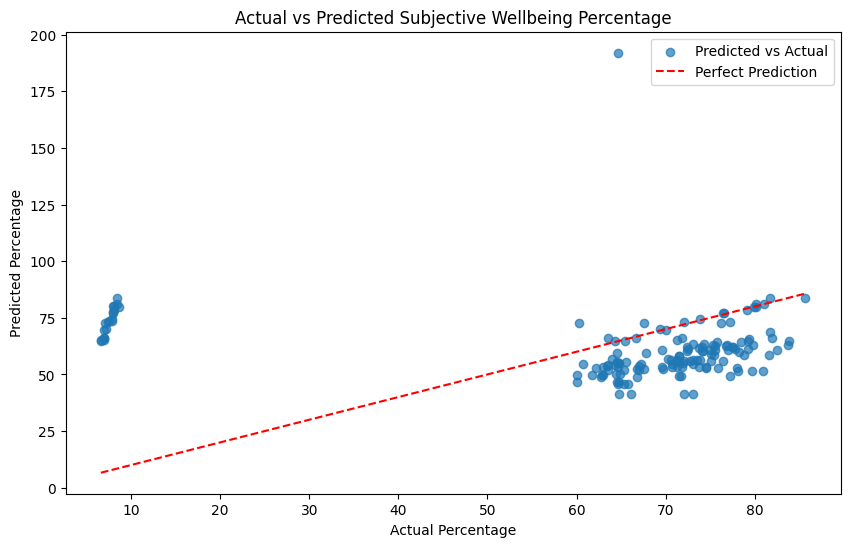

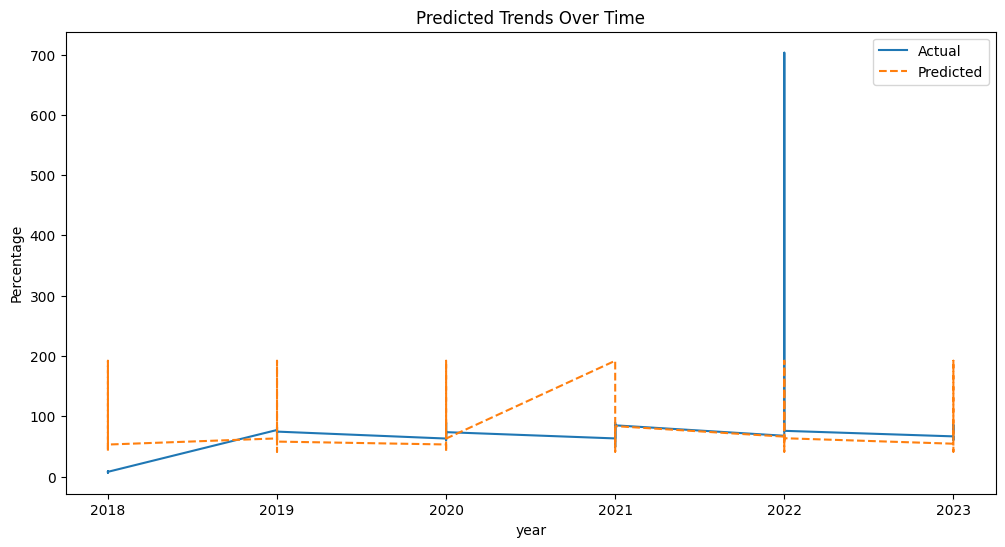

In [16]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Percentage")
plt.ylabel("Predicted Percentage")
plt.title("Actual vs Predicted Subjective Wellbeing Percentage")
plt.legend()
plt.savefig("visualizations/comparison_actual_vs_predicted.png")
plt.show()

# Plot Predicted Trends
plt.figure(figsize=(12, 6))
plt.plot(data['year'], data['Percentage'], label="Actual")
plt.plot(data['year'], data['Predicted_Percentage'], label="Predicted", linestyle='--')
plt.xlabel("year")
plt.ylabel("Percentage")
plt.title("Predicted Trends Over Time")
plt.legend()
plt.savefig("visualizations/predicted_trends.png")
plt.show()


In [17]:
from sklearn.metrics import r2_score

# Evaluate models
r2_linear = r2_score(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear Regression - R2 Score: {r2_linear}")
print(f"Random Forest - R2 Score: {r2_rf}")

# Choose the best model based on RMSE and R2
if rmse_rf < rmse_linear and r2_rf > r2_linear:
    best_model = rf_model
    print("Random Forest is the best model.")
else:
    best_model = linear_model
    print("Linear Regression is the best model.")


Linear Regression - R2 Score: -0.1426159549899486
Random Forest - R2 Score: -0.7574896082088569
Linear Regression is the best model.


In [19]:
# Load Data
data_path = "D:/Chathurni/src/data/processed/subjective_wellbeing_cleaned.csv"
data = pd.read_csv(data_path)

# Initialize Geolocator
geolocator = Nominatim(user_agent="health-behaviour-mapper")

# Function to Geocode Suburbs with Error Handling and Delay
def geocode_suburb(suburb):
    try:
        # Add a delay to avoid rate limiting
        time.sleep(1)
        # Skip invalid entries (e.g., "years" or complex combined locations)
        if "years" in suburb or "/" in suburb:
            return None, None
        # Geocode using Nominatim
        location = geolocator.geocode(suburb + ", Melbourne, Australia", timeout=15)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {suburb}: {e}")
        return None, None

# List to Track Failed Suburbs
failed_suburbs = []

# Apply Geocoding
def process_geocoding(data):
    for idx, row in data.iterrows():
        # Skip already geocoded entries
        if not pd.isnull(row.get("Latitude")) and not pd.isnull(row.get("Longitude")):
            continue
        lat, lon = geocode_suburb(row['Subcategory'])
        if lat and lon:
            data.at[idx, 'Latitude'] = lat
            data.at[idx, 'Longitude'] = lon
        else:
            failed_suburbs.append(row['Subcategory'])
        
        # Save progress incrementally
        data.to_csv("D:/Chathurni/src/data/processed/subjective_wellbeing_progress.csv", index=False)
    return data

# Ensure Latitude and Longitude Columns Exist
if 'Latitude' not in data.columns:
    data['Latitude'] = None
if 'Longitude' not in data.columns:
    data['Longitude'] = None

# Process Geocoding
updated_data = process_geocoding(data)

# Save Final Data
final_data_path = "D:/Chathurni/src/data/processed/subjective_wellbeing_cleaned_with_coordinates.csv"
updated_data.to_csv(final_data_path, index=False)
print(f"Geocoding completed. Final data saved to {final_data_path}")

# Print Failed Suburbs
if failed_suburbs:
    print("The following suburbs failed geocoding:")
    print(failed_suburbs)


Geocoding completed. Final data saved to D:/Chathurni/src/data/processed/subjective_wellbeing_cleaned_with_coordinates.csv
The following suburbs failed geocoding:
['35-44 years', '55-64 years', '65+ years', 'Kensington / Flemington 3031', '35-44 years', '45-54 years', 'South Yarra 3141 / Melbourne/St Kilda Road 3004', '35-44 years', '55-64 years', '65+ years', '18-24 years', '45-54 years', '65+ years', 'North Melbourne 3051 / West Melbourne 3003', '55-64 years', 'Kensington / Flemington 3031', '65+ years', 'Kensington / Flemington 3031', 'South Wharf / Southbank 3006', 'Kensington / Flemington 3031', 'North Melbourne 3051 / West Melbourne 3003', 'South Yarra 3141 / Melbourne/St Kilda Road 3004', '18-24 years', '45-54 years', 'South Yarra 3141 / Melbourne/St Kilda Road 3004', '18-24 years', '25-34 years', '65+ years', 'Kensington / Flemington 3031', '25-34 years', '45-54 years', 'Kensington / Flemington 3031', 'South Yarra 3141 / Melbourne/St Kilda Road 3004', '25-34 years', '35-44 year

In [3]:
import pandas as pd
import folium
from ipywidgets import widgets
from IPython.display import display

# Load cleaned data
data = pd.read_csv("data\processed\subjective_wellbeing_cleaned.csv")

# Example suburb locations (latitude and longitude) - Add real data as needed
suburb_locations = {
    "East Melbourne 3002": [-37.8136, 144.9841],
    "Kensington 3031": [-37.7941, 144.9276],
    "Flemington 3031": [-37.7891, 144.9210],
}

# Add geolocation to data
data['Latitude'] = data['Subcategory'].map(lambda x: suburb_locations.get(x, [None, None])[0])
data['Longitude'] = data['Subcategory'].map(lambda x: suburb_locations.get(x, [None, None])[1])

# Filter to valid locations
data = data.dropna(subset=['Latitude', 'Longitude'])


<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
C:\Users\chath\AppData\Local\Temp\ipykernel_18140\3143670047.py:7: SyntaxWarning: invalid escape sequence '\p'
  data = pd.read_csv("data\processed\subjective_wellbeing_cleaned.csv")
